Corey Glodek


# Libraries and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
#from scipy import ndimage
#from google.colab.patches import cv2_imshow # needed if colab is used
#import random as rng
import pandas as pd

## Helper functions

In [2]:
# a quick function to see impact thresholding 
def show_side_by_side(img1, img2, title1='Original Image', title2='Augmented Image'):

    titles = [title1,title2]

    images = [img1, img2]

    plt.figure(figsize=(20, 14))

    for i in range(2):
        plt.subplot(1,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.show()
    
def show_four(img1,img2,img3,img4):
    
    titles = ['Original Image', 'Edged Image', 'Fitted Elipse', 'Elipse on Origional Image']

    images = [img1, img2, img3,img4]

    plt.figure(figsize=(20, 14))

    for i in range(4):
        plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])
    plt.tight_layout()
    plt.show()
    
    
    
# Function to find the perimeter
# of an Ellipse
def perimeter(a, b):
    perimeter = 0

    # a = major axis /2
    a = a/2
    # b = minor axis /2
    b= b/2
    # Compute perimeter
    perimeter = (2 * np.pi * np.sqrt((a * a + b * b) / (2 * 1.0)));

    #print('Ellipse Perimeter: ',perimeter)

    return perimeter

# version 1
def in_bounds(dims):

    alphas = [0, 45, 90, 135, 180, 225, 270, 315]
    beta = dims[2]
    width = dims[1][0]/2
    height = dims[1][1]/2

    c_x = dims[0][0]
    c_y = dims[0][1]

    for alpha in alphas:
        x = width * np.cos(alpha) * np.cos(beta) - height * np.sin(alpha) * np.sin(beta) + c_x
        y = width * np.cos(alpha) * np.sin(beta) + height * np.sin(alpha) * np.cos(beta) + (540-c_y) 
        # adjustment for the difference between the standard xy coor and image coor system
        
        #print('X or Y : {}x {}y '.format(x,y))

        if x < 0 or y < 0 or x > 800 or y > 540:
            #print('X or Y were out of bounds: {}x {}y '.format(x,y))
            return None

    return dims

# Preprocessing


In [3]:
def preprocess(image, show=False):

    # median blurring allows for better results
    blur = cv2.medianBlur(image, 5)

    #  find the mean of the image
    im_mean = np.mean(blur)

    # apply binary threshold on the mean
    ret,b_img = cv2.threshold(blur, im_mean, 255, cv2.THRESH_BINARY)

    # structure 
    struct = np.ones((5,5), np.uint8)
    struct1 = np.ones((9,9), np.uint8)
    
    edi_img = cv2.erode(b_img, struct)
    edi_img = cv2.dilate(edi_img, struct)
    edi_img = cv2.erode(edi_img, struct1)
    edi_img = cv2.dilate(edi_img, struct)

    # subrtract the eroded image from the inital image
    edged_img = b_img - edi_img

    if show == True:
        show_side_by_side(image, edged_img, title2='Boundary Extraction')

    return edged_img

# Ellipse Fitting

In [4]:
# Version 2
# Works for fitting ellipse to the convex hull
# v2 - added perimeter, return ellipse perimeter (e_perimeter), and the ch_ellipse info

def fitHC(image, show=False):

    # calc the contours. Hierarchy is not used 
    contours, hier = cv2.findContours(image, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    # Copy of the image to draw contours and ellipses   
    drawing = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    color1 = (156, 19, 7) # fixed color for contours
    color = (66, 123, 235) # fixed color for ellipses and rectangles

    # initalize vars
    e_perimeter = None
    ch_ellipse = None

    for i, c in enumerate(contours):

    # draw the contours
      cv2.drawContours(drawing, contours, i, color1)

      # check if the contour is a likely fit
      if c.shape[0] > 500 and cv2.contourArea(contours[i])>25000:

        # Find the convex hull - reuse c_hull
        c_hull = cv2.convexHull(contours[i], clockwise=False)

        # fit an ellipse to the convexhull and check if it is within the bounds of the image
        c_test = in_bounds(cv2.fitEllipse(c_hull))

        if not c_test == None:

            # fit ellipse to convex hull
            # returns (xCenter,yCenter), (minor axis, major axis), angle
            ch_ellipse = c_test
            
            # gets the overall length of the perimeter via the helper function
            e_perimeter = perimeter(ch_ellipse[1][1],ch_ellipse[1][0])

            # draw the ellipse after fitting it 
            cv2.ellipse(drawing, ch_ellipse, color, 2)

    return drawing, e_perimeter, ch_ellipse

# Testing below

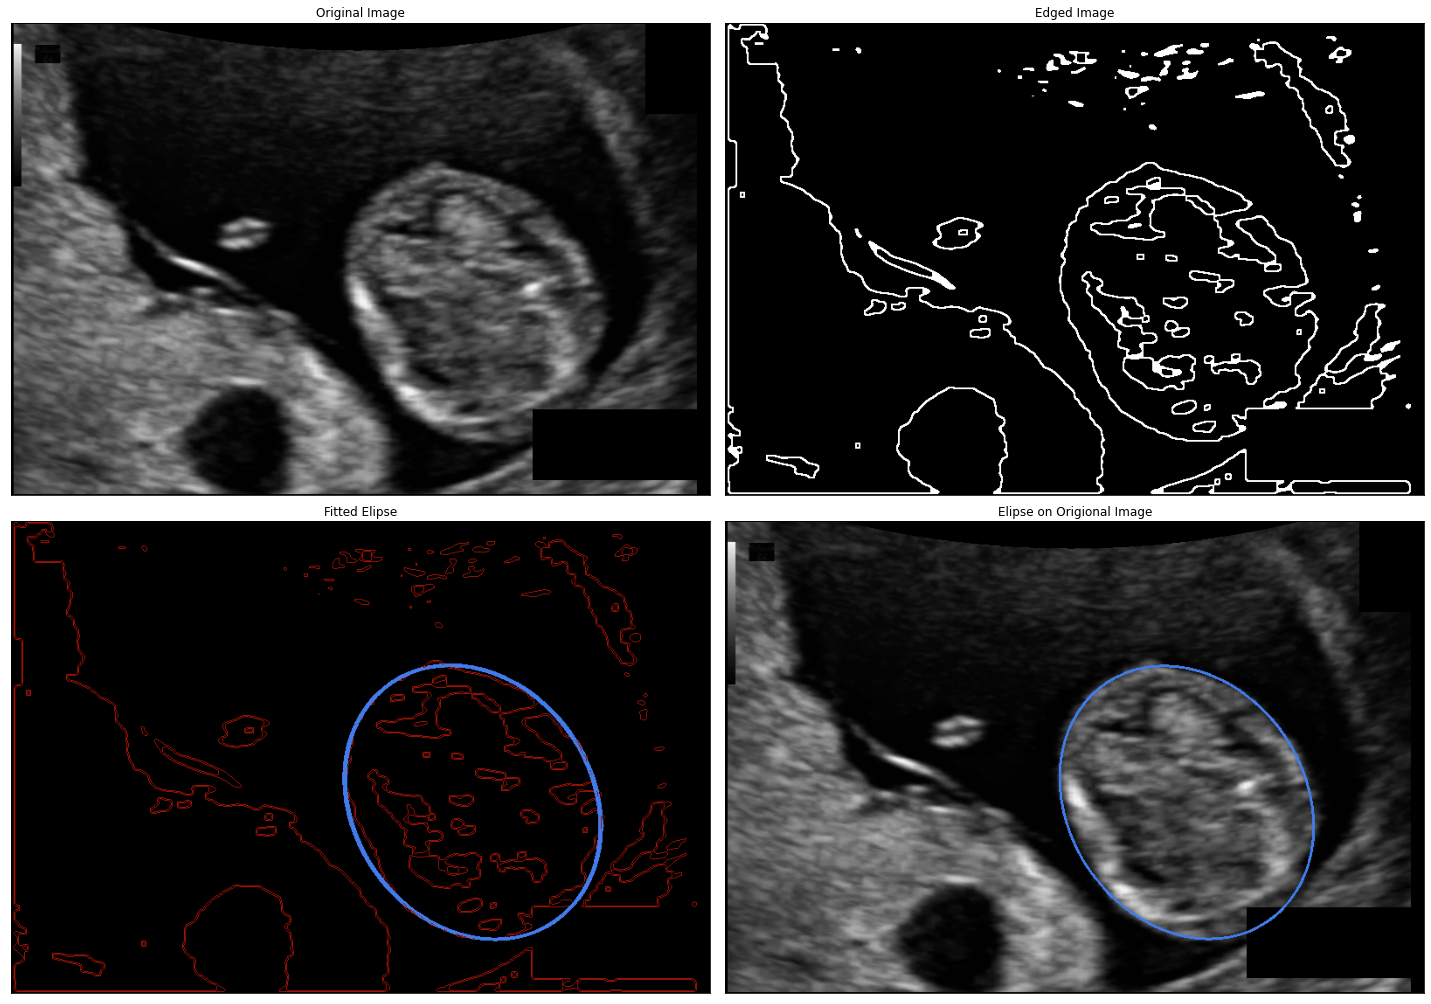

Ellispe Details:  ((527.9490966796875, 321.4469299316406), (271.0711669921875, 329.52294921875), 145.92721557617188)


In [5]:
# Import image
# 25 is a good example
# 637 and 784 example of bad image

img = cv2.imread('training_set\\025_HC.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# process image 
processed_img = preprocess(img, False)

# attempt to find ellipse
fit_img, img_perimeter, img_ellipse = fitHC(processed_img)

# place an Ellipse on the initial image
after_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.ellipse(after_img, img_ellipse, (66, 123, 235), 2)
show_four(img, processed_img, fit_img, after_img)

# Ellipse Details 
print('Ellispe Details: ', img_ellipse)

# Evaluating the training set

In [6]:
results = []

for i in range(806):
    if i < 10: 
        img = cv2.imread('training_set\\00{}_HC.png'.format(i))
    elif i < 100: 
        img = cv2.imread('training_set\\0{}_HC.png'.format(i))
    elif i < 1000: 
        img = cv2.imread('training_set\\{}_HC.png'.format(i))   
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    temp = preprocess(img, False)
    test, perimeter_test, ellipse_test = fitHC(temp)
    #show_side_by_side(img, test)
    results.append(perimeter_test)

In [7]:
# how many are nonZero
count = np.count_nonzero(results)
print('Total number of results found: ', count)
print('Percent of results found: ',(count/806)*100)

Total number of results found:  205
Percent of results found:  25.43424317617866


In [8]:
# read in the training set csv and compare results

result_df = pd.read_csv('training_set_pixel_size_and_HC.csv')

# strip out the images that werent used
result_df['length'] = result_df.filename.str.len()
result_df = result_df[result_df['length'] < 11]

# process results
result_df['Ellipse'] = results
result_df['measured perimeter'] = result_df['pixel size(mm)']* result_df['Ellipse']
result_df['diff'] = (result_df['measured perimeter']-result_df['head circumference (mm)'])
result_df['percent_off'] = abs((result_df['measured perimeter']-result_df['head circumference (mm)'])/result_df['head circumference (mm)'])*100

# drop all that did not produce an ellipse
df = result_df.dropna(subset=['percent_off'])
df.tail()

,filename,pixel size(mm),head circumference (mm),length,Ellipse,measured perimeter,diff,percent_off
963,779_HC.png,0.326114,296.76,10,1221.371557,398.305999,101.545999,34.218223
972,784_HC.png,0.240927,328.00,10,1587.165494,382.391205,54.391205,16.582684
979,789_HC.png,0.299029,315.30,10,1601.945641,479.028821,163.728821,51.927948
994,801_HC.png,0.296851,329.26,10,1790.721650,531.578097,202.318097,61.446303
997,804_HC.png,0.281090,316.48,10,1970.173219,553.795484,237.315484,74.985934


In [9]:
# details on the results
df['percent_off'].describe()

count    205.000000
mean      31.732592
std       38.466541
min        0.106759
25%        5.902197
50%       19.128218
75%       40.931727
max      280.788823
Name: percent_off, dtype: float64

In [10]:
# Get and print the MAD and SD
print('Measured Results including outliers')
mad = df['diff'].mad()
print('Median Absolute Deviation: ', mad)
std= df['diff'].std()
print('Standard Deviation: ', std)

Measured Results including outliers
Median Absolute Deviation:  61.963031104250035
Standard Deviation:  81.3504748751826


In [11]:
# filter on the items less than 75% quartile from above
df = df[df['percent_off'] < 40] 

In [12]:
print('Measured Results iexcluding outliers')
mad = df['diff'].mad()
print('Median Absolute Deviation: ', mad)
std= df['diff'].std()
print('Standard Deviation: ', std)

Measured Results iexcluding outliers
Median Absolute Deviation:  27.50977668267965
Standard Deviation:  39.89632266079206


In [13]:
df['percent_off'].describe()

count    151.000000
mean      14.242328
std       12.469796
min        0.106759
25%        4.124556
50%        9.579992
75%       25.653658
max       39.955665
Name: percent_off, dtype: float64

In [14]:
percent = (151/806)*100
print('Percent of total that found an ellipse: ', percent)

Percent of total that found an ellipse:  18.734491315136477
